In [ ]:
from google.colab import drive

!pip install scikit-survival
!pip install lifelines
!pip install torchtuples

!pip install scikit-learn==1.2.2
#!pip install --upgrade imbalanced-learn
!pip install imbalanced-learn==0.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=2743f8b720e814677cfcffa7a9d7b3f60b11514e2059e53b3937b2ffb5516d1f
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninst

In [ ]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import proportional_hazard_test
import matplotlib.pyplot as plt
import torch
import torchtuples as tt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
#from pycox.models import LogisticHazard
#from pycox.evaluation import EvalSurv
import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

import torch
import numpy as np
import random
import os

def seed_everything(seed=42):
    """
    Seed everything to make all operations in PyTorch deterministic.
    Args:
        seed (int): Seed value to set. Default is 42.
    """
    random.seed(seed)         # Python random module.
    np.random.seed(seed)      # Numpy module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # Set PYTHONHASHSEED env variable at a fixed value

    torch.manual_seed(seed)   # Sets the seed for generating random numbers for all devices (both CPU and CUDA).
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups.

    torch.backends.cudnn.deterministic = True  # Forces to use the deterministic algorithm
    torch.backends.cudnn.benchmark = False     # If True, causes cuDNN to benchmark multiple convolution algorithms and select the fastest.

seed_everything()

In [ ]:
from sksurv.datasets import load_whas500

### https://onlinelibrary.wiley.com/doi/epdf/10.1002/9780470258019.ch5
# Table 5.3


# Seed everything for reproducibility
seed_everything()

# Load the GBSG2 dataset
x, y = load_whas500()

# Create DataFrames
df_x = pd.DataFrame(x)
df_y = pd.DataFrame(y, columns=['fstat', 'lenfol'])

# Combine x and y into a single DataFrame
combined_df = pd.concat([df_x, df_y], axis=1)

Selected_predictors = ['age', 'bmi', 'gender',
               'hr',
               'sysbp', 'diasbp',
               'cvd', 'afb', 'chf',
               'miord', 'mitype',
               'fstat', 'lenfol']

combined_df = combined_df[Selected_predictors]

combined_df.rename(columns={
    'age': 'Age',
    'bmi': 'BMI',
    'gender': 'Sex',
    'hr': 'Heart Rate',
    'sysbp': 'SysBP',
    'diasbp': 'DiasBP',
    'cvd': 'CVD (M)',
    'afb': 'AF (M)',
    'chf': 'CHF (M)',
    'miord': 'MI Order',
    'mitype': 'MI Type',
    'lenfol': 'Duration',
    'fstat': 'Event'
}, inplace=True)

import copy

my_df = copy.copy(combined_df)

my_df["Event"] = my_df["Event"].astype(int)

for cCol in my_df.columns:
  my_df[cCol] = my_df[cCol].astype(float)

my_df.head()

,Age,BMI,Sex,Heart Rate,SysBP,DiasBP,CVD (M),AF (M),CHF (M),MI Order,MI Type,Event,Duration
0,83.0,25.54051,0.0,89.0,152.0,78.0,1.0,1.0,0.0,1.0,0.0,0.0,2178.0
1,49.0,24.02398,0.0,84.0,120.0,60.0,1.0,0.0,0.0,0.0,1.0,0.0,2172.0
2,70.0,22.14290,1.0,83.0,147.0,88.0,0.0,0.0,0.0,0.0,1.0,0.0,2190.0
3,70.0,26.63187,0.0,65.0,123.0,76.0,1.0,0.0,1.0,0.0,1.0,1.0,297.0
4,70.0,24.41255,0.0,63.0,135.0,85.0,1.0,0.0,0.0,0.0,1.0,0.0,2131.0


In [ ]:
from scipy import stats

In [ ]:
import copy
MY_DF = copy.copy(my_df)

#---
#Age [0]
#Age lambda:  1.6865934857959144
#Age min:     193.63449006596565
#Age max:     1326.0200598750828
MY_DF["Age"] = MY_DF["Age"].astype(float)
MY_DF["Age"] = stats.boxcox(MY_DF["Age"] + 1, lmbda = 1.6865934857959144)
MY_DF["Age"] = MY_DF["Age"] - 193.63449006596565
MY_DF["Age"] = MY_DF["Age"] / 1326.0200598750828

#---
#BMI [1]
#BMI lambda:  0.15302160670247952
#BMI min:     3.256380733893947
#BMI max:     1.9427518130395804
MY_DF["BMI"] = MY_DF["BMI"].astype(float)
MY_DF["BMI"] = stats.boxcox(MY_DF["BMI"] + 1, lmbda = 0.15302160670247952)
MY_DF["BMI"] = MY_DF["BMI"] - 3.256380733893947
MY_DF["BMI"] = MY_DF["BMI"] / 1.9427518130395804

#---
#Heart Rate [3]
#Heart Rate lambda:  0.27705021836536026
#Heart Rate min:     6.131813151671097
#Heart Rate max:     5.635170029359856
MY_DF["Heart Rate"] = MY_DF["Heart Rate"].astype(float)
MY_DF["Heart Rate"] = stats.boxcox(MY_DF["Heart Rate"] + 1, lmbda = 0.27705021836536026)
MY_DF["Heart Rate"] = MY_DF["Heart Rate"] - 6.131813151671097
MY_DF["Heart Rate"] = MY_DF["Heart Rate"] / 5.635170029359856

#---
#SysBP [4]
#SysBP lambda:  0.47800410176636404
#SysBP min:     12.47912988133779
#SysBP max:     14.44230060908183
MY_DF["SysBP"] = MY_DF["SysBP"].astype(float)
MY_DF["SysBP"] = stats.boxcox(MY_DF["SysBP"] + 1, lmbda = 0.47800410176636404)
MY_DF["SysBP"] = MY_DF["SysBP"] - 12.47912988133779
MY_DF["SysBP"] = MY_DF["SysBP"] / 14.44230060908183

#---
#DiasBP [5]
#DiasBP lambda:  0.8811316177674273
#DiasBP min:     5.168886943836562
#DiasBP max:     114.07537889986467
MY_DF["DiasBP"] = MY_DF["DiasBP"].astype(float)
MY_DF["DiasBP"] = stats.boxcox(MY_DF["DiasBP"] + 1, lmbda = 0.8811316177674273)
MY_DF["DiasBP"] = MY_DF["DiasBP"] - 5.168886943836562
MY_DF["DiasBP"] = MY_DF["DiasBP"] / 114.07537889986467

#---
#Duration [12]
#Duration lambda:  0.44204150577091594
#Duration min:     0.8110672042071864
#Duration max:     66.97904841362441
MY_DF["Duration"] = MY_DF["Duration"].astype(float)
MY_DF["Duration"] = stats.boxcox(MY_DF["Duration"] + 1, lmbda = 0.44204150577091594)
MY_DF["Duration"] = MY_DF["Duration"] - 0.8110672042071864
MY_DF["Duration"] = MY_DF["Duration"] / 66.97904841362441

MY_DF["Event"] = MY_DF["Event"].astype(int)

MY_DF = torch.tensor(MY_DF.values, dtype=torch.float32)

In [ ]:
# Define Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Linear(input_dim, input_dim, bias=False)  # Shape: (input_dim, input_dim)

    def forward(self, x, mask):
        # x: (batch_size, num_features)
        attention_scores = self.attention_weights(x)  # Shape: (batch_size, num_features)

        # Apply mask to the attention scores
        attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))  # Mask invalid positions

        # Compute softmax to get attention weights along feature dimension
        attention_weights = torch.softmax(attention_scores, dim=1)  # Shape: (batch_size, num_features)

        # Apply attention weights to the features (element-wise multiplication)
        weighted_sum = attention_weights * x  # Shape: (batch_size, num_features)

        return weighted_sum  # Return the attention-weighted features


# Define Attention + MLP Model
class AttentionMLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionMLPModel, self).__init__()
        self.attention = AttentionLayer(input_dim)  # Pass input_dim to AttentionLayer
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Linear layer after attention
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),  # Output size should match input_dim
            nn.Sigmoid()  # Sigmoid activation for output in range [0, 1]
        )

    def forward(self, x, mask):
        # Apply the attention mechanism
        attended_features = self.attention(x, mask)  # Shape: (batch_size, num_features)

        # Pass the attended features through the MLP
        predicted_values = self.mlp(attended_features)  # Shape: (batch_size, num_features)

        return predicted_values


In [ ]:
data = copy.copy(MY_DF)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Check if GPU is available and move tensors to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert dataset to tensor and move to the appropriate device
data = data.to(device)

# Create DataLoader for batches
batch_size = 16
dataset = TensorDataset(data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
input_dim = data.shape[1]
hidden_dim = 64
model = AttentionMLPModel(input_dim=input_dim, hidden_dim=hidden_dim).to(device)  # Move model to GPU

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import random

# Training parameters
epochs = 500
min_mask_ratio = 0.10  # Masking between 10% to 95% of data
max_mask_ratio = 0.95

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    model.train()  # Set model to training mode

    for batch in data_loader:
        inputs = batch[0].to(device)  # Move inputs to GPU
        mask = torch.ones_like(inputs).to(device)  # Initialize mask on GPU

        # Randomly mask 10-95% of the batch data, row-wise
        for i in range(inputs.size(0)):  # Iterate over batch rows
            mask_ratio = random.uniform(min_mask_ratio, max_mask_ratio)
            num_to_mask = int(inputs.size(1) * mask_ratio)
            mask_indices = random.sample(range(inputs.size(1)), num_to_mask)
            mask[i, mask_indices] = 0  # Apply mask (0 for missing data)

        # Forward pass through the model
        outputs = model(inputs, mask)

        # Calculate loss only on masked values
        loss = criterion(outputs * (1 - mask), inputs * (1 - mask))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print out loss for the epoch
    if (epoch+1) % 50 == 0:
      print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader):.4f}")


Epoch [50/500], Loss: 0.0554
Epoch [100/500], Loss: 0.0517
Epoch [150/500], Loss: 0.0511
Epoch [200/500], Loss: 0.0497
Epoch [250/500], Loss: 0.0501
Epoch [300/500], Loss: 0.0447
Epoch [350/500], Loss: 0.0475
Epoch [400/500], Loss: 0.0499
Epoch [450/500], Loss: 0.0446
Epoch [500/500], Loss: 0.0456


In [ ]:
# Create a copy of the original data for synthetic dataset generation
synth_df_MLM = copy.copy(MY_DF)

# Convert the DataFrame to a PyTorch tensor and move to GPU
synth_data_tensor = torch.tensor(synth_df_MLM, dtype=torch.float32).to(device)

# Set model to evaluation mode
model.eval()

# Initialize the mask with ones (no missing values initially)
mask = torch.ones_like(synth_data_tensor).to(device)

# Mask 10% of each row
mask_ratio = 0.25  # Masking 50% of each row
for i in range(synth_data_tensor.size(0)):  # Iterate over rows
    num_to_mask = int(synth_data_tensor.size(1) * mask_ratio)
    mask_indices = random.sample(range(synth_data_tensor.size(1)), num_to_mask)
    mask[i, mask_indices] = 0  # Apply the mask

# Forward pass through the model to fill the masked gaps
with torch.no_grad():  # No need to compute gradients during inference
    synthetic_output = model(synth_data_tensor, mask)

# Replace the masked values in the original dataset with the predicted values
synth_data_tensor = mask * synth_data_tensor + (1 - mask) * synthetic_output


<ipython-input-10-670ad8acf993>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  synth_data_tensor = torch.tensor(synth_df_MLM, dtype=torch.float32).to(device)


In [ ]:
def inverse_boxcox_pytorch(data, lmbda):
    """Apply the inverse Box-Cox transformation using PyTorch."""
    if lmbda != 0:
        return torch.exp(torch.log(lmbda * data + 1) / lmbda) - 1
    else:
        return torch.exp(data) - 1

if 1:
    synth_data_mod = synth_data_tensor.clone()  # Clone to avoid in-place operation

#---
#Age [0]
#Age lambda:  1.6865934857959144
#Age min:     193.63449006596565
#Age max:     1326.0200598750828
if 1:
    synth_data_mod[:, 0] = synth_data_mod[:, 0] * 1326.0200598750828 + 193.63449006596565
    synth_data_mod[:, 0] = inverse_boxcox_pytorch(synth_data_mod[:, 0], 1.6865934857959144)

#---
#BMI [1]
#BMI lambda:  0.15302160670247952
#BMI min:     3.256380733893947
#BMI max:     1.9427518130395804
if 1:
    synth_data_mod[:, 1] = synth_data_mod[:, 1] * 1.9427518130395804 + 3.256380733893947
    synth_data_mod[:, 1] = inverse_boxcox_pytorch(synth_data_mod[:, 1], 0.15302160670247952)

#---
#Heart Rate [3]
#Heart Rate lambda:  0.27705021836536026
#Heart Rate min:     6.131813151671097
#Heart Rate max:     5.635170029359856
if 1:
    synth_data_mod[:, 3] = synth_data_mod[:, 3] * 5.635170029359856 + 6.131813151671097
    synth_data_mod[:, 3] = inverse_boxcox_pytorch(synth_data_mod[:, 3], 0.27705021836536026)

#---
#SysBP [4]
#SysBP lambda:  0.47800410176636404
#SysBP min:     12.47912988133779
#SysBP max:     14.44230060908183
if 1:
    synth_data_mod[:, 4] = synth_data_mod[:, 4] * 14.44230060908183 + 12.47912988133779
    synth_data_mod[:, 4] = inverse_boxcox_pytorch(synth_data_mod[:, 4], 0.47800410176636404)

#---
#DiasBP [5]
#DiasBP lambda:  0.8811316177674273
#DiasBP min:     5.168886943836562
#DiasBP max:     114.07537889986467
if 1:
    synth_data_mod[:, 5] = synth_data_mod[:, 5] * 114.07537889986467 + 5.168886943836562
    synth_data_mod[:, 5] = inverse_boxcox_pytorch(synth_data_mod[:, 5], 0.8811316177674273)

#---
#Duration [12]
#Duration lambda:  0.44204150577091594
#Duration min:     0.8110672042071864
#Duration max:     66.97904841362441
if 1:
    synth_data_mod[:, 12] = synth_data_mod[:, 12] * 66.97904841362441 + 0.8110672042071864
    synth_data_mod[:, 12] = inverse_boxcox_pytorch(synth_data_mod[:, 12], 0.44204150577091594)

synth_data_df = pd.DataFrame(synth_data_mod.detach().cpu().numpy(), columns=my_df.columns)
synth_data_df.head()

,Age,BMI,Sex,Heart Rate,SysBP,DiasBP,CVD (M),AF (M),CHF (M),MI Order,MI Type,Event,Duration
0,67.962242,25.540510,0.0,89.000008,151.999939,84.242851,1.000000,1.00000,0.00000,0.609521,0.000000,0.000000,2177.998779
1,48.999992,24.023987,0.0,84.000000,143.572647,60.000019,1.000000,0.10436,0.00000,0.096070,1.000000,0.000000,2171.999268
2,69.999977,22.142906,1.0,82.999985,146.999954,88.000008,0.257988,0.00000,0.13845,0.000000,1.000000,0.000000,1154.331543
3,69.999977,26.631880,0.0,65.000008,137.327515,78.047470,1.000000,0.00000,1.00000,0.000000,1.000000,0.911693,296.999878
4,69.999977,24.412565,0.0,63.000000,135.000000,87.399338,1.000000,0.00000,0.00000,0.083134,0.846523,0.000000,2131.000244


In [ ]:
synth_df_MLM = copy.copy(synth_data_df)

In [ ]:
synth_df_MLM.columns

Index(['Age', 'BMI', 'Sex', 'Heart Rate', 'SysBP', 'DiasBP', 'CVD (M)',
       'AF (M)', 'CHF (M)', 'MI Order', 'MI Type', 'Event', 'Duration'],
      dtype='object')

In [ ]:
synth_df_MLM[['Sex', 'CVD (M)', 'AF (M)', 'CHF (M)', 'MI Order', 'MI Type', 'Event']] = \
  (synth_df_MLM[['Sex', 'CVD (M)', 'AF (M)', 'CHF (M)', 'MI Order', 'MI Type', 'Event']] > 0.5).astype(int)

In [ ]:
synth_df_MLM[['Age', 'BMI', 'Heart Rate', 'SysBP', 'DiasBP', 'Duration']] = \
  np.round(synth_df_MLM[['Age', 'BMI', 'Heart Rate', 'SysBP', 'DiasBP', 'Duration']])

In [ ]:
synth_df_MLM.head()

,Age,BMI,Sex,Heart Rate,SysBP,DiasBP,CVD (M),AF (M),CHF (M),MI Order,MI Type,Event,Duration
0,68.0,26.0,0,89.0,152.0,84.0,1,1,0,1,0,0,2178.0
1,49.0,24.0,0,84.0,144.0,60.0,1,0,0,0,1,0,2172.0
2,70.0,22.0,1,83.0,147.0,88.0,0,0,0,0,1,0,1154.0
3,70.0,27.0,0,65.0,137.0,78.0,1,0,1,0,1,1,297.0
4,70.0,24.0,0,63.0,135.0,87.0,1,0,0,0,1,0,2131.0


In [ ]:
import copy

synth_data_df = copy.copy(synth_df_MLM)

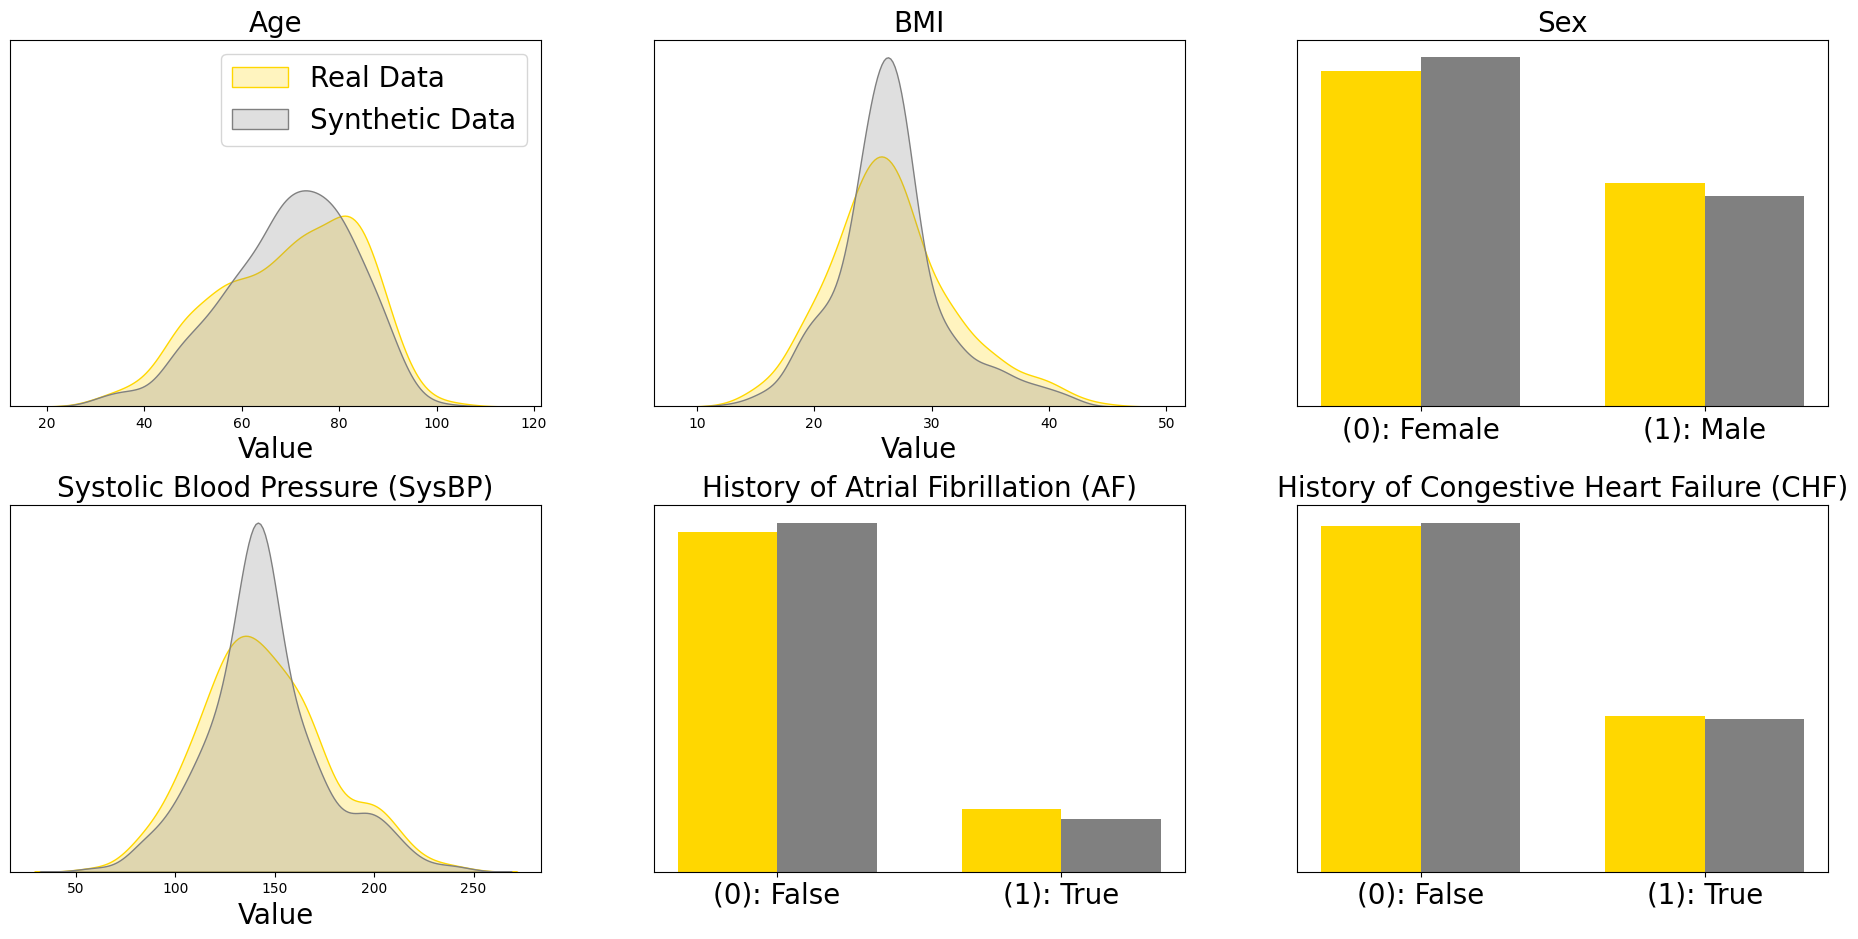

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your datasets are loaded as DataFrames
# my_df = pd.read_csv('path_to_my_df.csv')
# synth_data_df = pd.read_csv('path_to_synth_data_df.csv')

synth_data_df2 = synth_data_df[['Age', 'BMI', 'Sex',
                                'SysBP', 'AF (M)', 'CHF (M)', 'Event', 'Duration']]
# Mapping of column names to their types and clinical descriptions
variable_mapping = {
    'Age': {
        'type': 'numeric',
        'title': 'Age'
    },
    'BMI': {
        'type': 'numeric',
        'title': 'BMI'
    },
    'Sex': {
        'type': 'binary',
        'title': 'Sex',
        'xticks': ['(0): Female', '(1): Male']
    },
    'SysBP': {
        'type': 'numeric',
        'title': 'Systolic Blood Pressure (SysBP)'
    },
    'AF (M)': {
        'type': 'binary',
        'title': 'History of Atrial Fibrillation (AF)',
        'xticks': ['(0): False', '(1): True']
    },
    'CHF (M)': {
        'type': 'binary',
        'title': 'History of Congestive Heart Failure (CHF)',
        'xticks': ['(0): False', '(1): True']
    }
}

# Number of subplots based on the number of variables
num_vars = len(variable_mapping)

# Define number of columns and rows for subplots
ncols = 3
nrows = int(np.ceil(num_vars / ncols))

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
fig.tight_layout(pad=5.0)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each variable in a separate subplot
for i, (col, info) in enumerate(variable_mapping.items()):
    ax = axes[i]

    if info['type'] == 'binary':
        # Calculate proportions for 0 and 1 in both datasets
        real_counts = my_df[col].value_counts(normalize=True).sort_index()
        synth_counts = synth_data_df[col].value_counts(normalize=True).sort_index()

        # Align proportions for 0 and 1, filling missing values with 0
        real_counts = real_counts.reindex([0, 1], fill_value=0)
        synth_counts = synth_counts.reindex([0, 1], fill_value=0)

        # Define positions for side-by-side bars
        bar_width = 0.35
        index = np.arange(len(real_counts))

        # Bar plots for real and synthetic data
        bars_real = ax.bar(index, real_counts, bar_width, label='Real Data', color='gold')
        bars_synth = ax.bar(index + bar_width, synth_counts, bar_width, label='Synthetic Data', color='grey')

        # Set titles and labels
        ax.set_title(info['title'], fontsize=20)
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(info['xticks'], fontsize=20)

        # Hide y-ticks and y-labels
        ax.yaxis.set_ticks([])
        ax.set_ylabel('')

        # Adjust y-axis to accommodate the legend in the first subplot
        if i == 0:
            max_height = max(max(bars_real.get_height(), bars_synth.get_height()) for bars_real, bars_synth in zip(bars_real, bars_synth))
            ax.set_ylim(0, max_height * 1.5)
            ax.legend(loc='upper right')

    elif info['type'] == 'numeric':
        # KDE plot for numeric data
        sns.kdeplot(my_df[col], ax=ax, label='Real Data', color='gold', fill=True, common_norm=False)
        sns.kdeplot(synth_data_df[col], ax=ax, label='Synthetic Data', color='grey', fill=True, common_norm=False)

        # Set titles and labels
        ax.set_title(info['title'], fontsize=20)
        ax.set_xlabel('Value', fontsize=20)

        # Hide y-ticks and y-labels
        ax.yaxis.set_ticks([])
        ax.set_ylabel('')

        # Only show the legend for the first subplot
        if i == 0:
            ax.set_ylim(0, 0.05)
            ax.legend(loc='upper right', fontsize=20)
        else:
            ax.legend().set_visible(False)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Display the plots
plt.show()


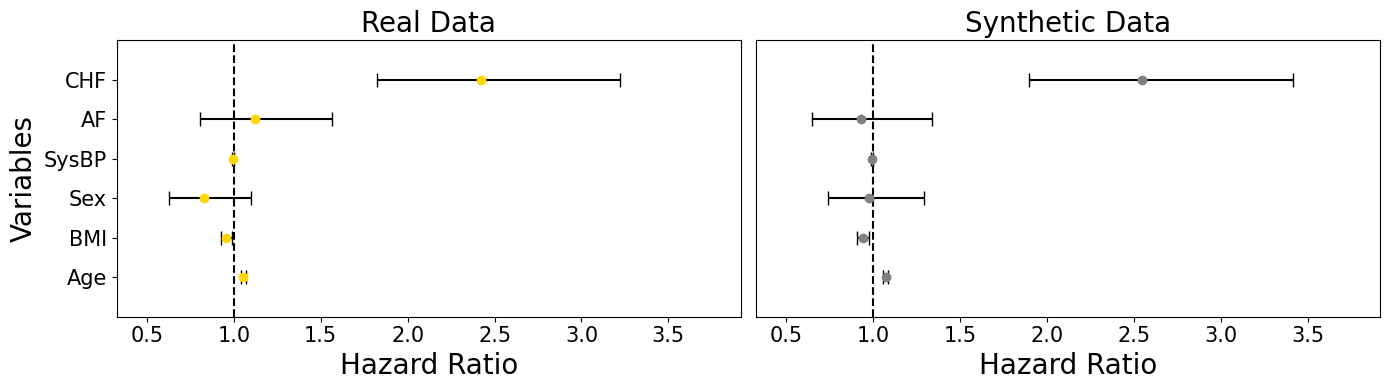

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
import numpy as np

# Assuming your datasets are loaded as DataFrames
# my_df = pd.read_csv('path_to_my_df.csv')
# synth_data_df = pd.read_csv('path_to_synth_data_df.csv')

# Drop "Unnamed: 0" if it exists in the synthetic data
synth_data_df = synth_data_df.loc[:, ~synth_data_df.columns.str.contains('^Unnamed')]

# Define clinically meaningful short descriptions
variable_mapping = {
    'Age': 'Age',
    'BMI': 'BMI',
    'Sex': 'Sex',
    'Heart Rate': 'Heart Rate',
    'SysBP': 'SysBP',
    'DiasBP': 'DiasBP',
    'CVD (M)': 'CVD',
    'AF (M)': 'AF',
    'CHF (M)': 'CHF',
    'MI Order': 'MI Order',
    'MI Type': 'MI Type'
}

# Rename the columns in both datasets using the variable_mapping
my_df.rename(columns=variable_mapping, inplace=True)
synth_data_df.rename(columns=variable_mapping, inplace=True)

# Initialize the Cox Proportional Hazards model
cph_real = CoxPHFitter()
cph_synth = CoxPHFitter()

# Fit the CoxPH model on the real data
cph_real.fit(my_df[my_df.columns[[0, 1, 2, 4, 7, 8, 11, 12]]],
             duration_col='Duration', event_col='Event')

# Fit the CoxPH model on the synthetic data
cph_synth.fit(synth_data_df[my_df.columns[[0, 1, 2, 4, 7, 8, 11, 12]]],
              duration_col='Duration', event_col='Event')

# Extract Hazard Ratios and Confidence Intervals from the summary
hr_real = cph_real.summary['exp(coef)']
ci_real_lower = cph_real.summary['exp(coef) lower 95%']
ci_real_upper = cph_real.summary['exp(coef) upper 95%']

hr_synth = cph_synth.summary['exp(coef)']
ci_synth_lower = cph_synth.summary['exp(coef) lower 95%']
ci_synth_upper = cph_synth.summary['exp(coef) upper 95%']

# Calculate the error bars for HRs
hr_real_lower_err = abs(hr_real - ci_real_lower)
hr_real_upper_err = abs(ci_real_upper - hr_real)

hr_synth_lower_err = abs(hr_synth - ci_synth_lower)
hr_synth_upper_err = abs(ci_synth_upper - hr_synth)

# Ensure the error arrays are correctly shaped
xerr_real = np.array([hr_real_lower_err.values, hr_real_upper_err.values])
xerr_synth = np.array([hr_synth_lower_err.values, hr_synth_upper_err.values])

# Determine the common xlim and ylim for both plots
xlim = (min(hr_real.min() - hr_real_lower_err.min(), hr_synth.min() - hr_synth_lower_err.min()) - 0.5,
        max(hr_real.max() + hr_real_upper_err.max(), hr_synth.max() + hr_synth_upper_err.max()) + 0.5)

ylim = (-1, len(hr_real))

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))

# Plot HRs and 95% CI for real data
axes[0].errorbar(hr_real, hr_real.index,
                 xerr=xerr_real,
                 fmt='o', color='gold', ecolor='black', capsize=5, label='HR (95% CI)')
axes[0].axvline(x=1, color='black', linestyle='--')
axes[0].set_title('Real Data', fontsize=20)
axes[0].set_xlabel('Hazard Ratio', fontsize=20)
axes[0].set_ylabel('Variables', fontsize=20)
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)

# Plot HRs and 95% CI for synthetic data
axes[1].errorbar(hr_synth, hr_synth.index,
                 xerr=xerr_synth,
                 fmt='o', color='grey', ecolor='black', capsize=5, label='HR (95% CI)')
axes[1].axvline(x=1, color='black', linestyle='--')
axes[1].set_title('Synthetic Data', fontsize=20)
axes[1].set_xlabel('Hazard Ratio', fontsize=20)
axes[1].set_ylabel('')
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

# Remove y-ticks from the right subplot
axes[1].yaxis.set_ticks([])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
